In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
#import statsmodels.stats.weightstats as ws
from scipy.stats import norm, ttest_ind

import os
import sys

import seaborn as sns
from scipy.stats import skewnorm, shapiro

In [146]:
df = pd.read_csv('Los_Angeles_Long_Beach_Anaheim_2.csv')
df

,DATE,CPI_all_items,Rent_of_Primary_residence,Monthly_Housing_Cost,CPI_Energy,US_Dollar_Purchasing_power
0,1997-01-01,159.400,158.400,155.400,113.800,62.8
1,1997-02-01,159.700,158.700,155.600,114.700,62.6
2,1997-03-01,159.800,158.500,155.500,117.400,62.5
3,1997-04-01,159.900,158.800,155.200,120.200,62.4
4,1997-05-01,159.900,159.100,156.100,121.200,62.5
...,...,...,...,...,...,...
307,2022-08-01,295.320,413.283,344.506,340.736,33.8
308,2022-09-01,296.539,416.569,346.521,335.502,33.7
309,2022-10-01,297.987,419.436,347.816,340.477,33.6
310,2022-11-01,298.598,422.562,348.720,336.248,33.6


In [167]:
def linear_interpolation(df):
    for column in df.columns:
        column_has_nan = df[column].isnull().any()
        if column_has_nan:
            for i, value in enumerate(df[column]):
                if np.isnan(value):
                    # Find previous value and index
                    prev_val = None
                    prev_idx = i - 1
                    while prev_idx >= 0:
                        if not np.isnan(df.at[prev_idx, column]):
                            prev_val = df.at[prev_idx, column]
                            break
                        prev_idx -= 1

                    # Find next value and index
                    next_val = None
                    next_idx = i + 1
                    while next_idx < len(df[column]):
                        if not np.isnan(df.at[next_idx, column]):
                            next_val = df.at[next_idx, column]
                            break
                        next_idx += 1

                    if prev_val is not None and next_val is not None:
                        # Calculate slope and missing value
                        slope = (next_val - prev_val) / (next_idx - prev_idx)
                        missing_value = prev_val + slope * (i - prev_idx)
                        df.at[i, column] = missing_value
                    elif prev_val is not None:
                        df.at[i, column] = prev_val
                    elif next_val is not None:
                        df.at[i, column] = next_val
    return df





df = linear_interpolation(df)
df.to_csv("completed_dataset.csv", index=False)
df

,DATE,CPI_all_items,Rent_of_Primary_residence,Monthly_Housing_Cost,CPI_Energy,US_Dollar_Purchasing_power
0,1997-01-01,159.400,158.400,155.400,113.800,62.8
1,1997-02-01,159.700,158.700,155.600,114.700,62.6
2,1997-03-01,159.800,158.500,155.500,117.400,62.5
3,1997-04-01,159.900,158.800,155.200,120.200,62.4
4,1997-05-01,159.900,159.100,156.100,121.200,62.5
...,...,...,...,...,...,...
307,2022-08-01,295.320,413.283,344.506,340.736,33.8
308,2022-09-01,296.539,416.569,346.521,335.502,33.7
309,2022-10-01,297.987,419.436,347.816,340.477,33.6
310,2022-11-01,298.598,422.562,348.720,336.248,33.6


## Section 3.5

## 3.5.1

AlphaMME: 262.9066321347529 and BetaMME: 1.0564014631524605 found for column CPI_Energy


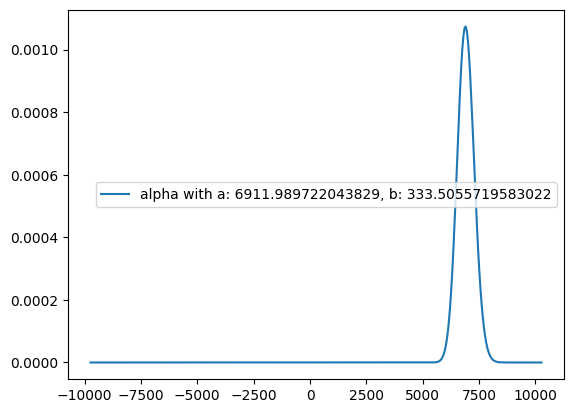

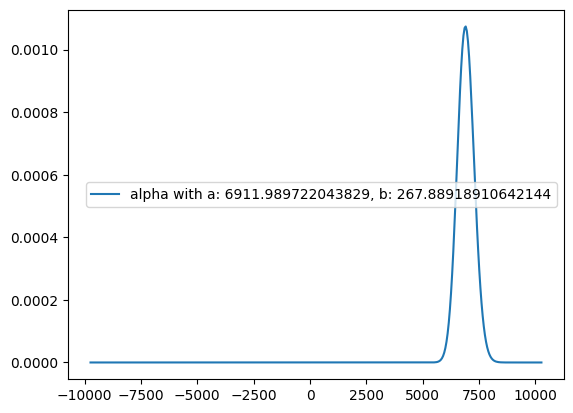

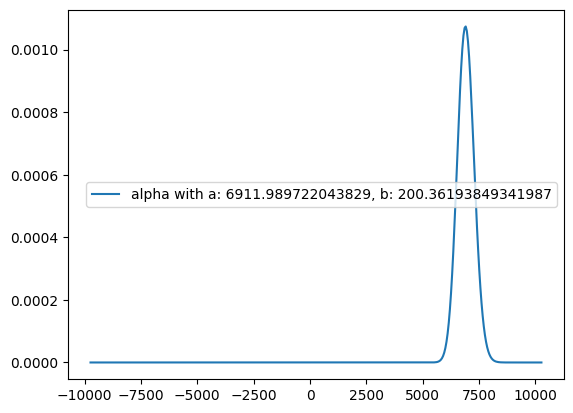

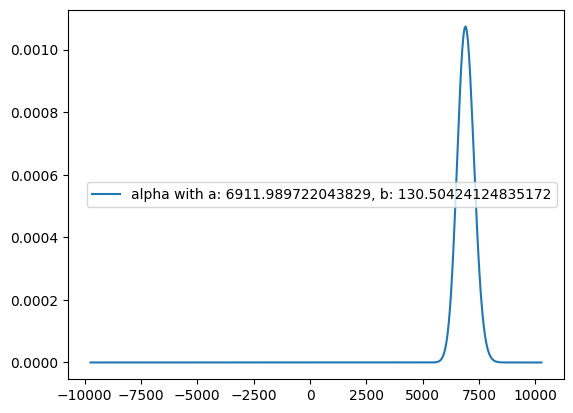

In [201]:
def calculate_gamma_mme(df,year_range,column):
    """
    alpha_mme = sum(Xi)**2/sum(Xi**2)
    beta_mme = sample(Mean)/(sum(Xi**2)/n)
    """
    
    ndf = df.copy(deep=True)
    
    ndf = ndf[(ndf['DATE'] >= year_range[0]) & (ndf['DATE'] <= year_range[1])]
    
    col_val = np.array(ndf[column])
    
    alpha_mme = (col_val.mean())**2/(col_val.var())
    
    beta_mme = (col_val.mean())/col_val.var()
    
    return alpha_mme,beta_mme
alpha_mme,beta_mme = calculate_gamma_mme(df,['2015-01-01','2018-12-31'],'CPI_Energy')
print("AlphaMME: {} and BetaMME: {} found for column {}".format(alpha_mme,beta_mme,'CPI_Energy')) 
"""
alpha = Gamma(a,b)
Beta = Gamma(c,d)

a = alpha_mme**2/var(alpha)

b = alpha_mme/var(alpha)

c = beta_mme**2/var(beta)
d = beta_mme/var(beta)
"""

var_vec = np.arange(10,100,10)

a_vec = [alpha_mme**2/v for v in var_vec]
b_vec = [alpha_mme/v for v in var_vec]

c_vec = [beta_mme**2/v for v in var_vec]
d_vec = [beta_mme/v for v in var_vec]

def plot_posterior_alpha(a,b,df,year,column):
    ndf = df.copy(deep=True)
    ndf = ndf[(ndf['DATE'] >= year+'-01-01') & (ndf['DATE'] <= year+'-12-31')]
    samples = ndf[column].to_numpy()
    a_new = a
    b_new = b - (np.log(samples).sum())
    
    return a_new,b_new

def plot_posterior_beta(c,d,df,year,column):
    
    ndf = df.copy(deep=True)
    ndf = ndf[(ndf['DATE'] >= year+'-01-01') & (ndf['DATE'] <= year+'-12-31')]
    samples = ndf[column].to_numpy()
    c_new = c
    d_new = d + samples.sum()
    
    return c_new,d_new
years = ['2019','2020','2021','2022']
a_prior = a_vec[0]
b_prior = 400

c_prior = c_vec[0]
d_prior = 1000
for year in years:
    a_post,b_post = plot_posterior_alpha(a_prior,b_prior,df,year,'CPI_Energy')
    c_post,d_post = plot_posterior_beta(c_prior,d_prior,df,year,'CPI_Energy')
    
    alpha_x = np.linspace(alpha_mme -10000,alpha_mme+10000,400) 
   # alpha_y = stats.gamma.pdf(alpha_x, a=a_post, scale=b_post)
    alpha_y = stats.gamma.pdf(alpha_x, a=a_post, scale=)
    plt.plot(alpha_x, alpha_y,label = 'alpha with a: {}, b: {}'.format(a_post,b_post))
    
    #beta_x = np.linspace (0, 40, 100) 
    #beta_y = stats.gamma.pdf(beta_x, a=c_post, scale=d_post)
    #plt.plot(beta_x, beta_y,label = 'beta with c: {}, d: {}'.format(c_post,d_post))
    
    a_prior = a_post
    b_prior = b_post
    c_prior = c_post
    d_priro = d_post
     
    plt.legend()
    plt.show()

   
    
    
    
    




## 3.5.2

In [222]:
def remove_outliers(ndf,alpha):
    df = ndf.copy(deep=True)
    for col in df.columns:
        if col != 'DATE':
            column_df = df[col]
            Q1 = column_df.quantile(0.25)
            Q3 = column_df.quantile(0.75)
            IQR  = Q3 -Q1 

            low_range = Q1 - IQR * alpha
            upper_range = Q3 +  IQR * alpha
            for i,val in enumerate(column_df):
                if val < low_range or val > upper_range:
                    df.at[i,col] = None
    return df

def linear_interpolation_pc(df):
    for column in df.columns:
        column_has_nan = df[column].isnull().any()
        if column_has_nan:
            for i, value in enumerate(df[column]):
                if np.isnan(value):
                    # Find previous value and index
                    prev_val = None
                    prev_idx = i - 1
                    while prev_idx >= 0:
                        if not np.isnan(df.at[prev_idx, column]):
                            prev_val = df.at[prev_idx, column]
                            break
                        prev_idx -= 1

                    # Find next value and index
                    next_val = None
                    next_idx = i + 1
                    while next_idx < len(df[column]):
                        if not np.isnan(df.at[next_idx, column]):
                            next_val = df.at[next_idx, column]
                            break
                        next_idx += 1

                    if prev_val is not None and next_val is not None:
                        # Calculate slope and missing value
                        slope = (next_val - prev_val) / (next_idx - prev_idx)
                        missing_value = prev_val + slope * (i - prev_idx)
                        df.at[i, column] = missing_value
                    elif prev_val is not None:
                        df.at[i, column] = prev_val
                    elif next_val is not None:
                        df.at[i, column] = next_val
    return df
def calculate_percentage_change(df,column):
    ndf = df.copy(deep=True)
    for column in ndf.columns:
        if column != 'DATE':
            for i,val in enumerate(ndf[column]):
                #print(i,val)
                if i!=0:
                    #print((ndf.at[i,column] - ndf.at[i-1,column]))
                    k= (df.at[i,column] - df.at[i-1,column])*100/(df.at[i-1,column])
                    ndf.at[i,column] = k
    ndf = ndf.drop([0])
    ndf = ndf.rename(lambda x:  x+'_per_change' if (x != 'DATE') else x,axis ='columns')
    ndf = ndf.reset_index()
    #ndf = remove_outliers(ndf,1.0)
    #display(ndf)
    return linear_interpolation_pc(ndf)

MME Mean for years {} is {}, Sigma is {} ['2015-01-01', '2018-12-31'] 0.18717232801818365 4.021372129730647
estimate of m is 0.18717232801818365 and s is 0.5804350704029119


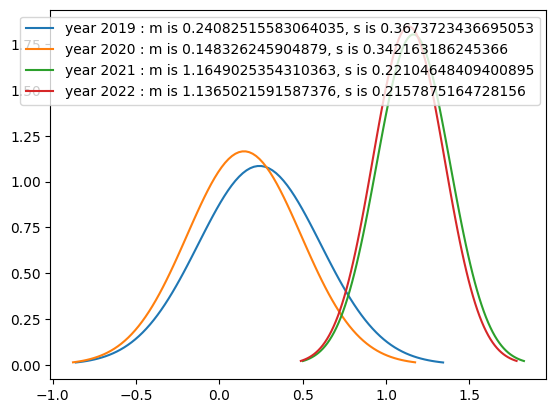

In [233]:
ndf = calculate_percentage_change(df,"DATE")

def calculate_mme_normal(df,year_range,column):
    ndf = df.copy(deep=True)
    ndf = ndf[(ndf['DATE'] >= year_range[0]) & (ndf['DATE'] <= year_range[1])]
    col_val = np.array(ndf[column])
    mu_mme = col_val.mean()
    sigma_mme = np.sqrt(col_val.var())
    return mu_mme,sigma_mme

def calculate_mu_m_s(df,year_range,column):
    ndf = df.copy(deep=True)
    ndf = ndf[(ndf['DATE'] >= year_range[0]) & (ndf['DATE'] <= year_range[1])]
    col_val = np.array(ndf[column])
    m = col_val.mean()
    s = np.sqrt(col_val.var()/len(col_val))
    return m,s
mu_mme,sigma_mme = calculate_mme_normal(ndf,['2015-01-01','2018-12-31'],'CPI_Energy_per_change')
    
m,s = calculate_mu_m_s(ndf,['2015-01-01','2018-12-31'],'CPI_Energy_per_change')

print('MME Mean for years {} is {}, Sigma is {}',['2015-01-01','2018-12-31'],mu_mme,sigma_mme)
print('estimate of m is {} and s is {}'.format(m,s))

def calculate_posterior_normal(m,s,df,year,column):
    ndf = df.copy(deep=True)
    ndf = ndf[(ndf['DATE'] >= year + '-01-01') & (ndf['DATE'] <= year+'-12-31')]
    col_val = np.array(ndf[column])
    s_mean = col_val.mean()
    s_var = col_val.var()
    sigma = np.sqrt(s_var/len(col_val))
    mu_post = ((s**2)*s_mean + (sigma**2)*m)/(s**2+ sigma**2)
    
    sigma_post = np.sqrt((s**2)*(sigma**2)/((s**2+ sigma**2)))
    
    return mu_post,sigma_post
years = ['2019','2020','2021','2022']

m_prior = m
s_prior = s
for year in years:
    m_post,s_post=calculate_posterior_normal(m_prior,s_prior,ndf,year,'CPI_Energy_per_change')
    
    x = np.linspace(m_post - 3*s_post, m_post + 3*s_post, 100)
    plt.plot(x, stats.norm.pdf(x, m_post, s_post),label = 'year {} : m is {}, s is {}'.format(year,m_post,s_post))
    
    m_prior = m_post
    s_prior = s_post
plt.legend()
plt.show()

    

## 3.5.3

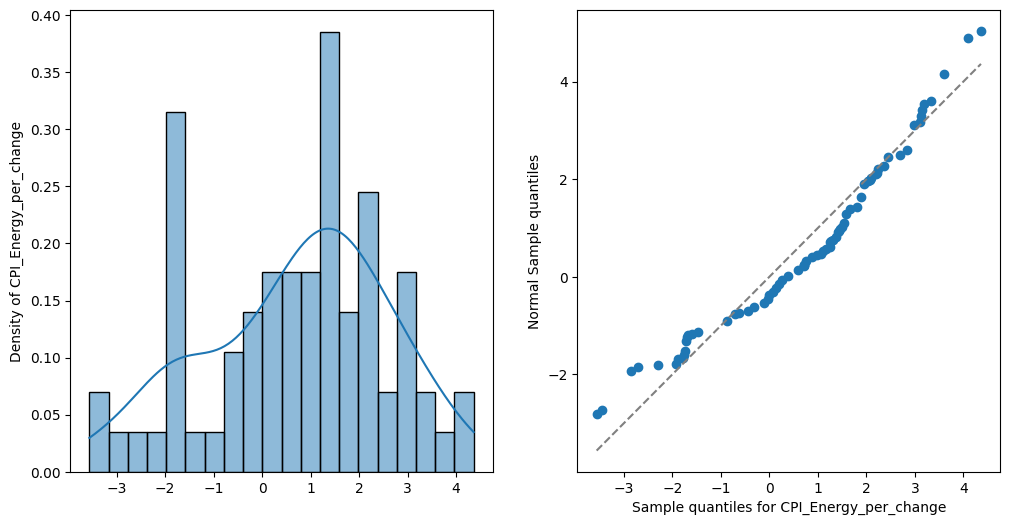

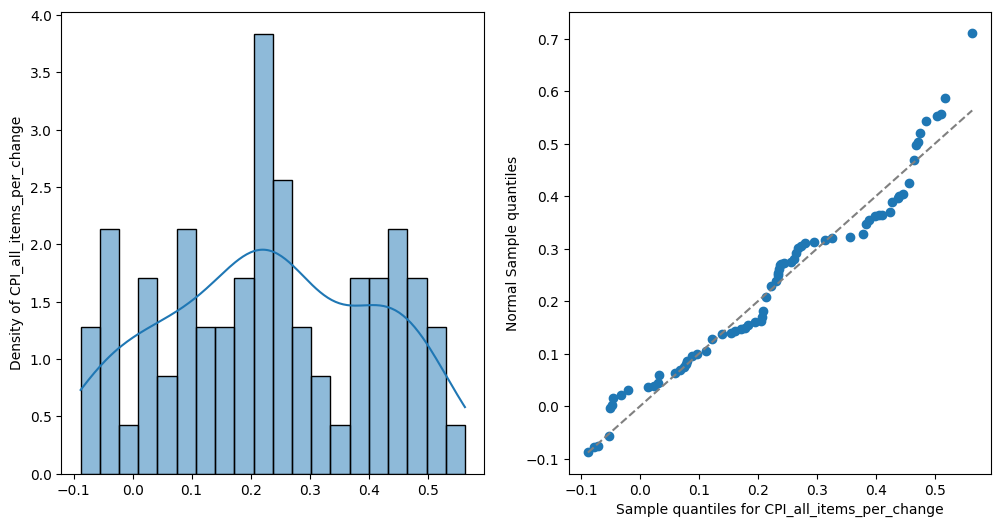

Shapiro-Wilk test statistic for column CPI_Energy_per_change: 0.9684540629386902
p-value: 0.06743162125349045
Shapiro-Wilk test statistic for column CPI_all_items_per_change: 0.9659985899925232
p-value: 0.04861230030655861


In [220]:
def plot_q_q(df,columns,year_range):
    ndf = df.copy(deep = True)
    ndf = ndf[(ndf['DATE'] >= year_range[0]) & (ndf['DATE'] <= year_range[1])]
    
    for column in columns:
        sample  = ndf[column].to_numpy()
        sample_size = len(sample)
        sample_sorted = np.sort(sample)
        mu = sample.mean()
        sigma = np.sqrt(sample.var())
        normal_sample  = np.random.normal(mu, sigma, sample_size)
        normal_sample_sorted  = np.sort(normal_sample)
        
        p = np.arange(1, sample_size+1) / sample_size
        q1 = np.quantile(sample_sorted, p)
        q2 = np.quantile(normal_sample_sorted, p)
        #q3 = np.quantile(sample3_sorted, p)

# Plot Q-Q plot
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
        sns.histplot(q1, ax=ax1, bins=20, kde=True, stat="density")
        ax1.set_ylabel('Density of {}'.format(column))
        ax2.scatter(q1, q2)
        ax2.plot([q1.min(), q1.max()], [q1.min(), q1.max()], '--', color='gray')
        ax2.set_xlabel('Sample quantiles for ' + column)
        ax2.set_ylabel('Normal Sample quantiles')
        plt.show()
        
        
ndf = calculate_percentage_change(df,"DATE")
plot_q_q(ndf,['CPI_Energy_per_change','CPI_all_items_per_change'],['2016-01-01','2021-12-31'])
        
def wilks_test(df,columns,year_range):
    

    # perform Shapiro-Wilk test on the samples
    ndf = df.copy(deep = True)
    ndf = ndf[(ndf['DATE'] >= year_range[0]) & (ndf['DATE'] <= year_range[1])]
    
    for column in columns:
        sample  = ndf[column].to_numpy()
        sample_size = len(sample)
        mu = sample.mean()
        sigma = np.sqrt(sample.var())
        stat, p = shapiro(sample)

    # print the test statistic and p-value
        print("Shapiro-Wilk test statistic for column {}: {}".format(column,stat))
        print("p-value: {}".format(p))

wilks_test(ndf,['CPI_Energy_per_change','CPI_all_items_per_change'],['2016-01-01','2021-12-31'])

## 3.5.4

,index,DATE,CPI_all_items_per_change,Rent_of_Primary_residence_per_change,Monthly_Housing_Cost_per_change,CPI_Energy_per_change,US_Dollar_Purchasing_power_per_change
0,1,1997-02-01,0.188206,0.189394,0.128700,0.790861,-0.318471
1,2,1997-03-01,0.062617,0.189334,-0.064267,2.353967,-0.159744
2,3,1997-04-01,0.062578,0.189274,-0.192926,2.385009,-0.160000
3,4,1997-05-01,0.000000,0.188917,0.579897,0.831947,0.160256
4,5,1997-06-01,0.187617,0.125707,0.192184,-0.495050,-0.160000
...,...,...,...,...,...,...,...
306,307,2022-08-01,0.234872,0.690709,0.636526,-3.444680,0.000000
307,308,2022-09-01,0.412773,0.689475,0.584895,-1.536087,-0.295858
308,309,2022-10-01,0.488300,0.688241,0.373715,1.482853,-0.296736
309,310,2022-11-01,0.205043,0.688241,0.259908,-1.242081,0.000000


0.40567951318458995 -0.8547008547008517


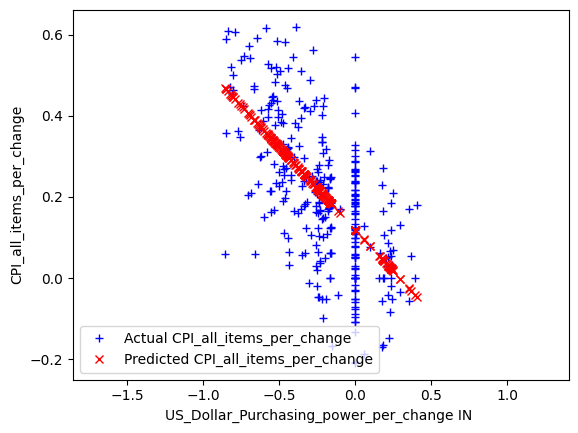

SSE for linear regression with columns ['US_Dollar_Purchasing_power_per_change'] is 6.148990477224352
0.40567951318458995 -0.8547008547008517


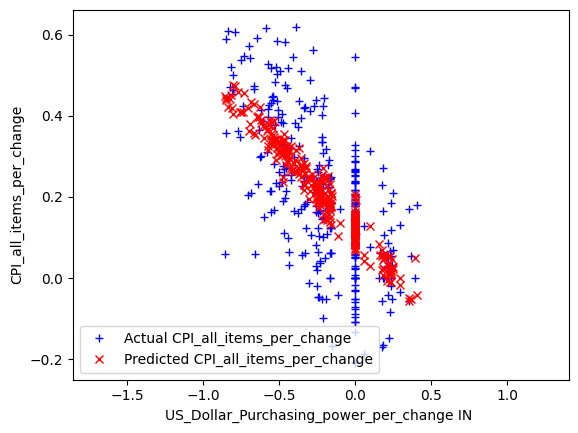

7.601572739187415 -6.285482562854826


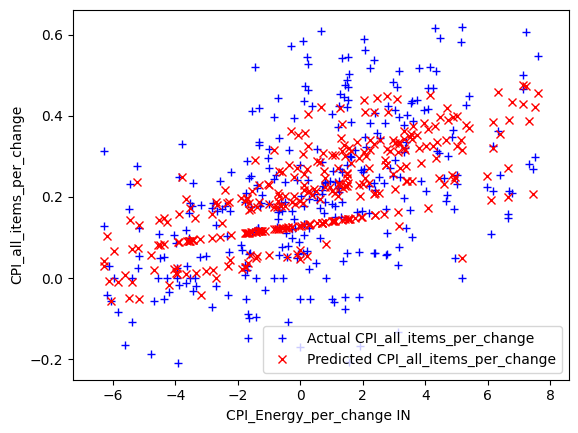

SSE for linear regression with columns ['US_Dollar_Purchasing_power_per_change', 'CPI_Energy_per_change'] is 5.924733457449252
0.40567951318458995 -0.8547008547008517


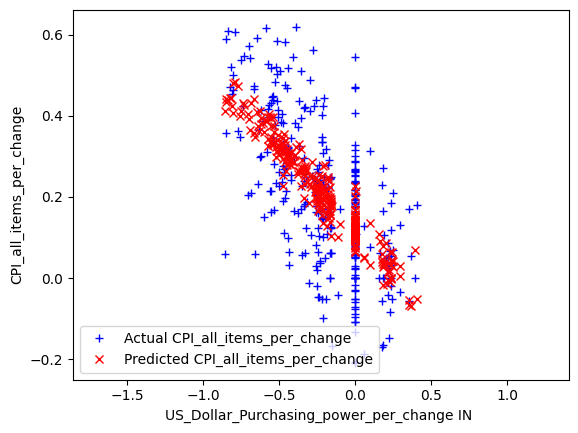

7.601572739187415 -6.285482562854826


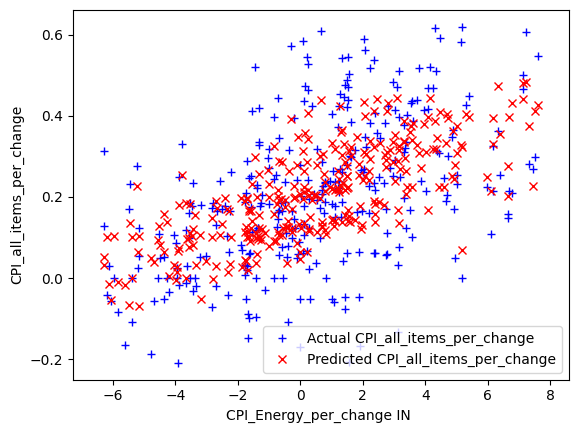

0.8746355685131112 -0.32249920596786474


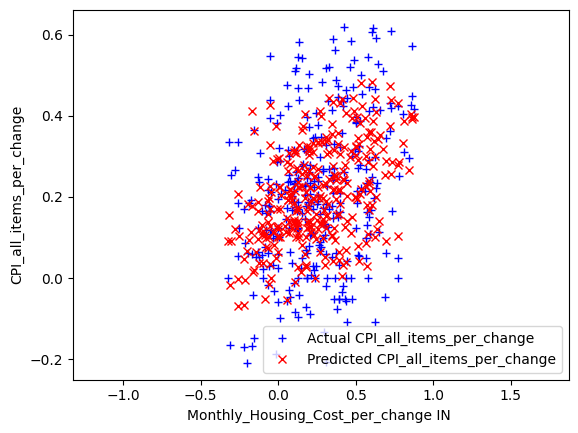

SSE for linear regression with columns ['US_Dollar_Purchasing_power_per_change', 'CPI_Energy_per_change', 'Monthly_Housing_Cost_per_change'] is 5.85533813198168
0.40567951318458995 -0.8547008547008517


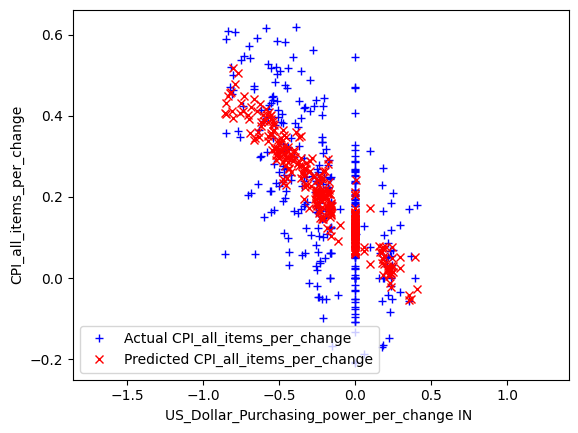

7.601572739187415 -6.285482562854826


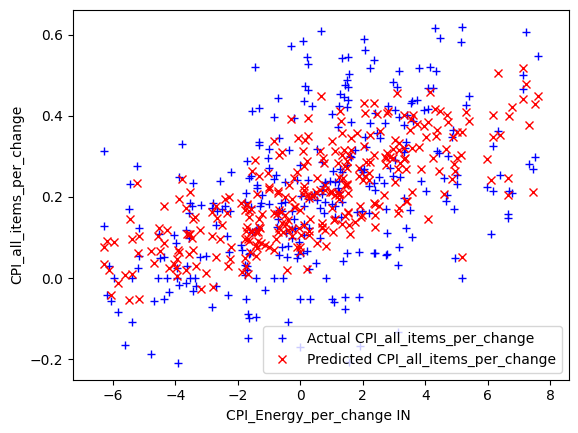

0.8746355685131112 -0.32249920596786474


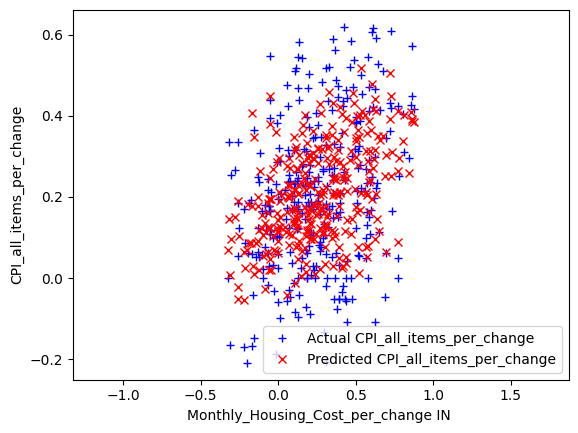

0.7124895222129158 -0.08920103374480139


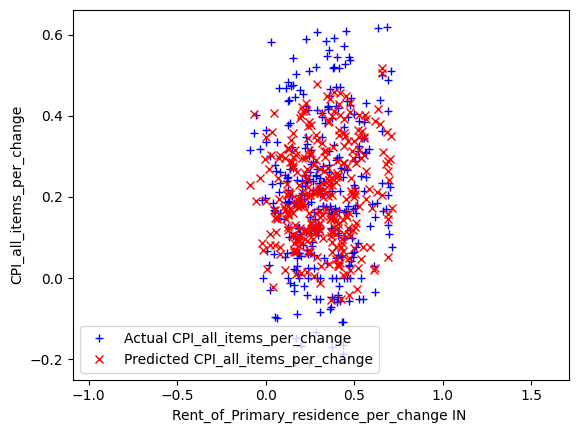

SSE for linear regression with columns ['US_Dollar_Purchasing_power_per_change', 'CPI_Energy_per_change', 'Monthly_Housing_Cost_per_change', 'Rent_of_Primary_residence_per_change'] is 5.760136163043867


In [221]:
def linear_regression(df,y_column,x_columns):
    nY = df[y_column].to_numpy()
    #print(x_columns)
    nX = df[x_columns].to_numpy()

    weights = np.matmul(np.linalg.inv(np.matmul(nX.transpose(),nX)),np.matmul(nX.transpose(),nY))
    y_predicts = np.matmul(nX,weights)
    sse = ((nY-y_predicts)**2).sum()
    for column in x_columns:
        X = df[column].to_numpy()
        if(column != 'ones'):
            print(max(X), min(X))
            plt.plot(X,nY,'b+',label = 'Actual {}'.format(y_column))
            plt.plot(X,y_predicts,'rx', label = 'Predicted {}'.format(y_column))
            plt.legend()
            plt.xlim(right = max(X)+1,left = min(X)-1)
            plt.xlabel('{} IN {}'.format(column,""))
            plt.ylabel(y_column)
            plt.show()
    
    return sse,weights
#ndf = calculate_percentage_change(df,"DATE")
ndf = calculate_percentage_change(df,"DATE")
y_column = 'CPI_all_items_per_change'
x_columns = ['US_Dollar_Purchasing_power_per_change', 'CPI_Energy_per_change', 'Monthly_Housing_Cost_per_change','Rent_of_Primary_residence_per_change']
display(ndf)
for i in range(len(x_columns)):
    nx_columns = x_columns[:i+1]
    nx_columns.insert(0,'ones')
    ndf['ones'] = pd.Series([1 for x in range(len(df.index))])
    sse,weights = linear_regression(ndf,y_column,nx_columns)
    print("SSE for linear regression with columns {} is {}".format(nx_columns[1:],sse))

# 3.7

In [166]:
df = pd.read_csv('Los_Angeles_Long_Beach_Anaheim_2.csv')

def fill_value(ndf,columns):
    df = ndf.copy(deep=True)
    df['DATE'] = pd.to_datetime(df['DATE'])

# create a new column 'YEAR' to store the year of each date
    df['YEAR'] = df['DATE'].dt.year

# calculate the year-wise average and store it in a dictionary
    year_avg = {}
    for year in df['YEAR'].unique():
        avg = df.loc[df['YEAR'] == year].mean(numeric_only=True)
        year_avg[year] = avg

# replace NaN values with year-wise average
    for column in columns:
        for index, row in df.iterrows():
            if pd.isna(row[column]):
                year = row['YEAR']
                avg = year_avg[year][column]
                df.at[index, column] = avg
    
    return pd.DataFrame(df[['DATE']+columns])
ndf = fill_value(df,['Monthly_Housing_Cost','CPI_all_items'])
display(ndf)

def create_matrix(df,categories):
    mat = {}
    for column in df.columns:
        mat[column] = []
        for cat in categories:
            cat_num = 0
            for i,value in enumerate(df[column]):
                if value == cat:
                    cat_num+=1
            mat[column].append(cat_num)
    df = pd.DataFrame(mat)
    
    df.index = categories
    df = df.transpose()
    total_row = pd.DataFrame(df.sum(axis=0)).T
    total_row.index = ['Column_Total']
    df = df.append(total_row)
    df = df.assign(Row_Total=df.sum(axis=1))
    return df
            
                
        
def chi_square(df,year_range):
    ndf = df.copy(deep = True)
    ndf = ndf[(ndf['DATE'] >= year_range[0]) & (ndf['DATE'] <= year_range[1])]
    for column in df.columns:    
        if column != 'DATE':
            column_median = df[column].median()
            ndf['CAT_'+column] = ['high' if x >= column_median else 'low' for x in ndf[column]]
            #result = ndf.groupby(column)['CAT_'+column].value_counts().unstack().fillna(0)
            ndf = ndf.drop(columns = [column])
    ndf = ndf.drop(columns=['DATE'])
    #ndf = pd.DataFrame(ndf['CAT_'+column for column in columns and column != 'DATE'])
    categories = ['high','low']
    
    print("Original Values")
    mat_df = create_matrix(ndf,categories)
    display(mat_df)
    
    # Expected Matrix
    print("Expected Values")
    ex_mat = {}
    for col in mat_df.columns[:-1]:
        ex_mat[col] = []
        for row in mat_df.index[:-1]:
            ex_val = mat_df.loc[row,mat_df.columns[-1]] * mat_df.loc[mat_df.index[-1],col]/mat_df.loc[mat_df.index[-1],mat_df.columns[-1]]
            ex_mat[col].append(ex_val)
    ex_df = pd.DataFrame(ex_mat)
    ex_df.index = mat_df.index[:-1]
    display(ex_df)
    
    chi_sum = 0
    
    for row in ex_df.index:
        for col in ex_df.columns:
            chi_sum += (ex_df.loc[row,col] - mat_df.loc[row,col])**2/(ex_df.loc[row,col])
    dof = (len(ex_df.index)-1)*(len(ex_df.columns)-1)
    return dof,chi_sum
    
dof,chi_sum = chi_square(ndf,['1997-01-01','2021-12-31'])
print("Chi Sum is {}".format(chi_sum))

,DATE,Monthly_Housing_Cost,CPI_all_items
0,1997-01-01,155.400,159.400
1,1997-02-01,155.600,159.700
2,1997-03-01,155.500,159.800
3,1997-04-01,155.200,159.900
4,1997-05-01,156.100,159.900
...,...,...,...
307,2022-08-01,344.506,295.320
308,2022-09-01,346.521,296.539
309,2022-10-01,347.816,297.987
310,2022-11-01,348.720,298.598


Original Values


/var/folders/bd/fd299p6d3356dz5ycbkjv_s80000gn/T/ipykernel_68895/350354157.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(total_row)


,high,low,Row_Total
CAT_Monthly_Housing_Cost,144,156,300
CAT_CPI_all_items,144,156,300
Column_Total,288,312,600


Expected Values


,high,low
CAT_Monthly_Housing_Cost,144.0,156.0
CAT_CPI_all_items,144.0,156.0


Chi Sum is 0.0
